# Sales Forecast Exercise

```
docker run --rm -v $(pwd):/home/jovyan/ -p 8888:8888 jupyter/datascience-notebook
```

## Install Dependencies

In [119]:
%%capture install_deps
!pip install tabulate stumpy

In [120]:
import pandas as pd
import numpy as np

## Plotting & Smelling the Data

In [121]:
sales_data = pd.read_csv("training.csv", parse_dates=["TSDate"], index_col="TSDate")
sales_data['date'] = sales_data.index

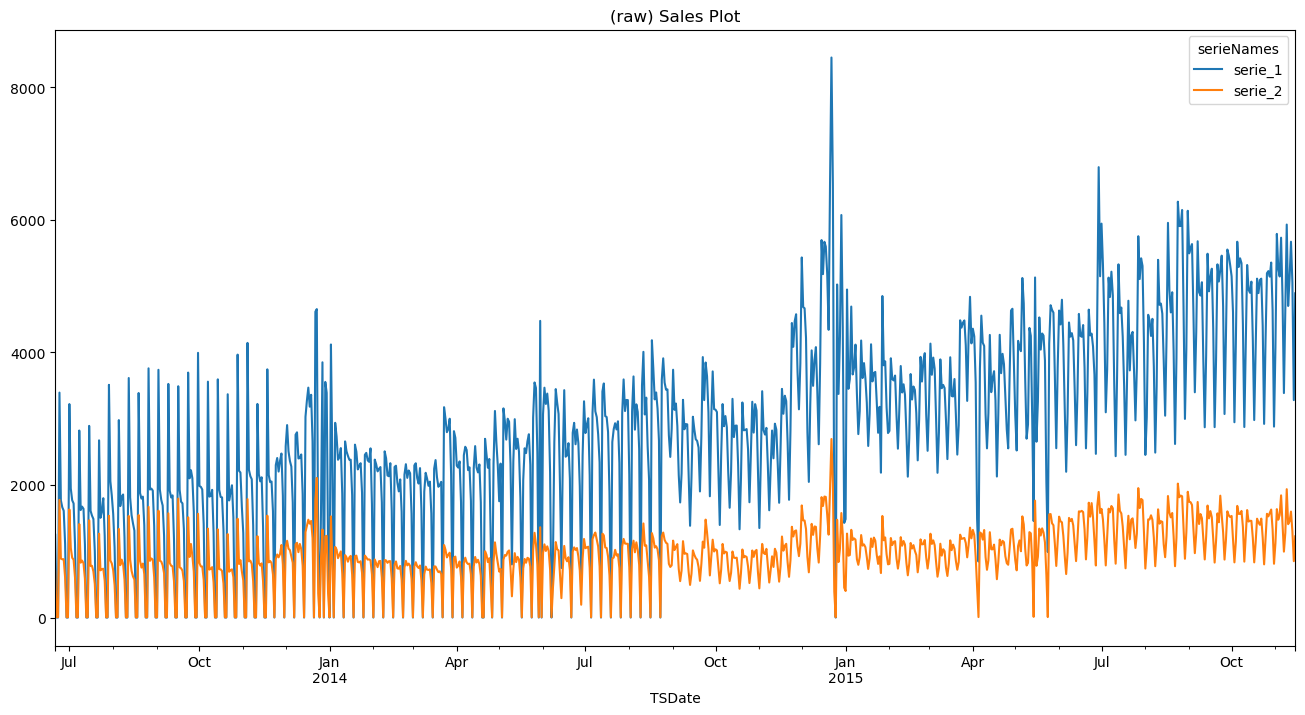

In [122]:
_ = sales_data.pivot(columns="serieNames", values="sales").plot(title='(raw) Sales Plot', figsize=(16,8))

In [123]:
# Pivoting the sales_data dataframe so that we have each 'serieNames' as a 
# column and their respective 'sales' as the column's values
pivotted_data = sales_data.pivot(columns="serieNames", values="sales")

# Filtering the data for the years 2015, 2014 and 2013 respectively
year_2015 = pivotted_data[ pivotted_data.index.year == 2015 ]
year_2014 = pivotted_data[ pivotted_data.index.year == 2014 ]
year_2013 = pivotted_data[ pivotted_data.index.year == 2013 ]

# Adding 365 days (one year) to each index in the 2013 data. 
# This is done to align the data with that of 2014 for comparison purposes. 
year_2013.index = year_2013.index + pd.Timedelta(days=365)

# Subtracting 365 days (one year) from each index in the 2015 data.
# This is done to align the data with that of 2014 for comparison purposes.
year_2015.index = year_2015.index - pd.Timedelta(days=365)

# Renaming the columns of year_2015 data to indicate that they represent series shifted one year back
year_2015.columns = ['serie_1_year_shifted_back', 'serie_2_year_shifted_back']

# Renaming the columns of year_2013 data to indicate that they represent series shifted one year forward
year_2013.columns = ['serie_1_year_shifted_forw', 'serie_2_year_shifted_forw']

In [124]:
years_combined = pd.concat([year_2013, year_2014, year_2015], axis=1)

In [125]:
_ = years_combined.plot(title="All Year Overlapped", figsize=(16,8))

In [126]:
years_combined['date'] = years_combined.index
weekly_sum = years_combined.groupby([pd.Grouper(key='date', freq='W')]).sum()
weekly_sum = weekly_sum[ weekly_sum.index.year == 2014 ]
weekly_sum.index = weekly_sum.index.isocalendar().week
_ = weekly_sum.plot(title="Weekly Sales (sum over weeks)", figsize=(16,8))

In [127]:
weekly_sum[weekly_sum.index >= 45] / weekly_sum.mean()

serie_1_year_shifted_forw  serie_2_year_shifted_forw   serie_1   
week                                                                   
45                     2.037902                   1.906583  1.030756  \
46                     1.857246                   1.649965  1.004920   
47                     1.971559                   1.844979  1.164052   
48                     2.310926                   2.196945  1.615269   
49                     2.443270                   2.366847  1.546334   
50                     2.497535                   2.411971  1.448706   
51                     3.225940                   3.226948  2.184691   
52                     2.682783                   2.535571  1.654023   

       serie_2  serie_1_year_shifted_back  serie_2_year_shifted_back  
week                                                                  
45    1.040794                   1.427142                   1.418679  
46    0.985423                   1.171063                   1.058032  
47    1.146764                   0.000000                   0.000000  
48    1.417824                   0.000000                   0.000000  
49    1.460757                   0.000000                   0.000000  
50    1.449172                   0.000000                   0.000000  
51    2.024514                   0.000000                   0.000000  
52    1.439461                   0.000000                   0.000000

In [128]:
kerst_drukte = { 47: 1.10,
 48: 1.40,
 49: 1.40,
 50: 1.40,
 51: 2.00,
 52: 1.50,}

In [129]:
kerst_drukte

{47: 1.1, 48: 1.4, 49: 1.4, 50: 1.4, 51: 2.0, 52: 1.5}

## What is the 'day-of-week' pattern?

The day of the week with Monday=0, Sunday=6.


In [130]:
last_few_weeks = pivotted_data[pivotted_data.index > pd.Timestamp('2015-8-2')]
last_few_weeks = last_few_weeks.copy()
last_few_weeks['day_of_week'] = last_few_weeks.index.dayofweek
_ = last_few_weeks[['serie_1', 'serie_2']].plot()

In [131]:
last_few_weeks['serie_1_average'] = last_few_weeks[['serie_1']] / 4646
last_few_weeks['serie_2_average'] = last_few_weeks[['serie_2']] / 1383 


In [132]:
day_patterns = last_few_weeks.groupby('day_of_week').mean() / 7

In [133]:
day_patterns

serieNames      serie_1     serie_2  serie_1_average  serie_2_average
day_of_week                                                          
0            794.066667  241.895238         0.170914         0.174906
1            725.961905  216.952381         0.156255         0.156871
2            727.980952  224.771429         0.156690         0.162525
3            752.238095  226.095238         0.161911         0.163482
4            629.504762  180.095238         0.135494         0.130221
5            424.980952  122.457143         0.091472         0.088545
6            591.628571  171.285714         0.127341         0.123851

In [134]:
week_pattern = {0: 0.17, 1: 0.16, 2: 0.16, 3: 0.16, 4: 0.13, 5: 0.09, 6: 0.13 }

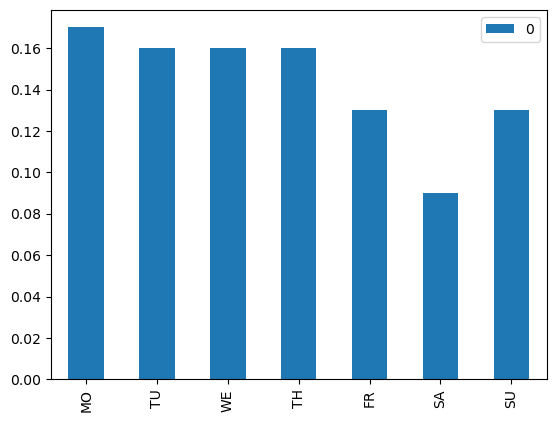

In [135]:
_ = pd.DataFrame(week_pattern.values(), index=['MO','TU','WE','TH','FR','SA','SU']).plot(kind='bar', )

In [136]:
special_days = sales_data[(sales_data.serieNames == "serie_1") & (sales_data.sales < 1500) & (sales_data.index > pd.Timestamp('2015-1-1') ) ]

In [137]:
sales_data = pd.read_csv("training.csv", parse_dates=["TSDate"], index_col="TSDate")

In [138]:
s_1 = sales_data[sales_data.serieNames=="serie_1"].copy()
s_2 = sales_data[sales_data.serieNames=="serie_2"].copy()

s_1['date'] = s_1.index
s_2['date'] = s_2.index

## Define the Predictions Methods

In [139]:
def add_rolling_mean_predictions(df, date_to_start_predictions=None, add_name=False):
    """
    This function computes the rolling mean predictions of sales based on the previous weeks' sales.

    Parameters:
    df (pd.DataFrame): The input dataframe which contains the 'sales' and 'serieNames' data.
    date_to_start_predictions (pd.Timestamp, optional): The date to start predictions. If not specified, the function will consider the last date in the dataframe.
    add_name (bool, optional): If True, the name of the series will be added to the prediction dataframe. Default is False.

    Returns:
    pd.DataFrame: The dataframe containing predictions.

    The function works by first identifying the closest Monday to the given 'date_to_start_predictions'. It then selects data up to this date and groups sales data on a weekly basis. It computes the mean sales of the last three weeks to serve as a weekly sales prediction. If 'add_name' is True, the name of the series is added to the returned dataframe.

    """
    closest_monday = date_to_start_predictions - pd.Timedelta(days=date_to_start_predictions.day_of_week)
    until_monday = df[ df.index < closest_monday ]
    weekly_sums = until_monday.groupby([pd.Grouper(key='date', freq='W')])['sales'].sum()
    average_last_3_weeks = int(weekly_sums.tail(3).mean())
    
    name=df['serieNames'][0]
    
    predictions =  rolling_mean_to_prediction(weekly_mean=average_last_3_weeks, serie=name, monday=closest_monday, add_name=add_name)
    
    return predictions

In [140]:
def rolling_mean_to_prediction( serie="serie_", weekly_mean=0, special_events=kerst_drukte, week_pattern=week_pattern, monday=pd.Timestamp('2015-11-15'), weeks_to_predict=3, add_name=False):
    predictions = [ int(weekly_mean*day_proportion) for k,day_proportion in week_pattern.items()] * weeks_to_predict
    date_start = monday 
    date_end = monday + pd.Timedelta(days=7*weeks_to_predict-1)
    date_index = pd.date_range(date_start, date_end)
    df = pd.DataFrame(predictions, index=date_index, columns=["sales_predictions"])
    
    df['week'] = df.index.isocalendar().week
    df['factor'] = df['week'].map(special_event_factor)
    df['sales_predictions'] =  df['sales_predictions'] * df['factor']
    df['sales_predictions'] = df['sales_predictions'].astype('int')

    if add_name:
        df['serieNames'] = serie
    #df['serieNames'] = serie
    #df['TSDate'] = df.index
    
    return df

In [141]:
def plot_predictions_and_actuals_around(date=pd.Timestamp('2015-2-15'), df=None):
    print(date)
    preds = add_rolling_mean_predictions(df, date_to_start_predictions=date)
    
    with_preds = df.join(preds, how='outer')
    plot_start = date-pd.Timedelta(days=30)
    plot_end = date+pd.Timedelta(days=30)
    
    df_to_plot =  with_preds[ (with_preds.index > plot_start) & (with_preds.index < plot_end) ][['sales','sales_predictions']]
    df_to_plot.plot(figsize=(12,4))

In [142]:
def special_event_factor(week_number):
    return kerst_drukte.get(week_number, 1)

## The "Real" Metric to optimize, forecast 100K Products

- 5 Seconds to calculate all necessary weekly means
- <3 minutes, with a 'naive' approve to calculate & construct all predictions


In [143]:
def generate_random_timeseries(time_series_number=3, start_date=pd.Timestamp('2015-09-01'), end_date=pd.Timestamp('2015-11-15')):
    # Generate dates between start_date and end_date
    dates = pd.date_range(start_date, end_date)
    
    # Create a DataFrame with n random time series
    df = pd.DataFrame(np.random.randint(low=0, high=1000, size=(len(dates), 1)), index=dates, columns=["sales"])
    df['serieNames'] = f"serie_{time_series_number}"
    
    return df

In [144]:
BIG_N = 100*1000

In [145]:
few_dfs = [ generate_random_timeseries(time_series_number=i) for i in range(4,BIG_N) ]

In [146]:
many_products = pd.concat( few_dfs )

In [147]:
many_products['date'] = many_products.index

In [148]:
many_products.head()

sales serieNames       date
2015-09-01    523    serie_4 2015-09-01
2015-09-02    851    serie_4 2015-09-02
2015-09-03    142    serie_4 2015-09-03
2015-09-04    876    serie_4 2015-09-04
2015-09-05    357    serie_4 2015-09-05

In [149]:
%%time
weekly_sales_sums = many_products.groupby(['serieNames', pd.Grouper(key='date', freq='W')])['sales'].sum()

CPU times: user 6.63 s, sys: 7.85 s, total: 14.5 s
Wall time: 14.7 s


In [150]:
%%time
only_last_3 = weekly_sales_sums.groupby("serieNames").tail(3)

CPU times: user 247 ms, sys: 48.7 ms, total: 296 ms
Wall time: 290 ms


In [151]:
%%time
mean_of_last_3_weeks = only_last_3.groupby("serieNames").mean()

CPU times: user 158 ms, sys: 17 ms, total: 175 ms
Wall time: 166 ms


In [152]:
%%time
P = [ rolling_mean_to_prediction(serie=name, weekly_mean=mean, add_name=True) for name,mean in  mean_of_last_3_weeks.items()]

CPU times: user 3min 31s, sys: 1.21 s, total: 3min 32s
Wall time: 3min 31s


In [153]:
%%time
all_predictions = pd.concat(P)

CPU times: user 12.8 s, sys: 1.12 s, total: 13.9 s
Wall time: 13.9 s


## Some Prediction/Actual Plots

### Series 1

2013-10-15 00:00:00


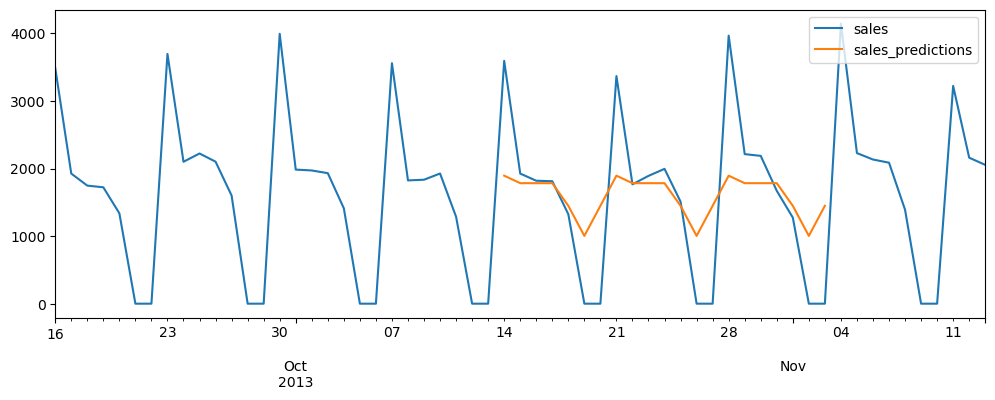

In [154]:
plot_predictions_and_actuals_around(df=s_1, date=pd.Timestamp('2013-10-15'))

2014-11-15 00:00:00


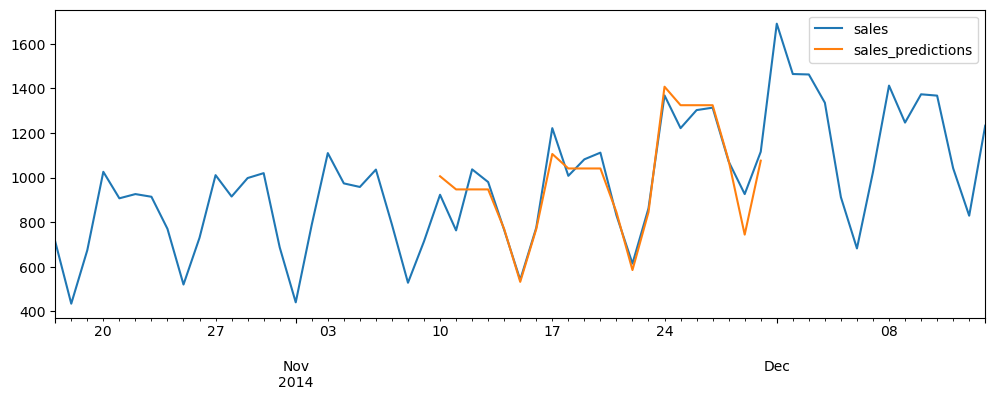

In [155]:
plot_predictions_and_actuals_around(df=s_2, date=pd.Timestamp('2014-11-15'))

2014-11-30 00:00:00


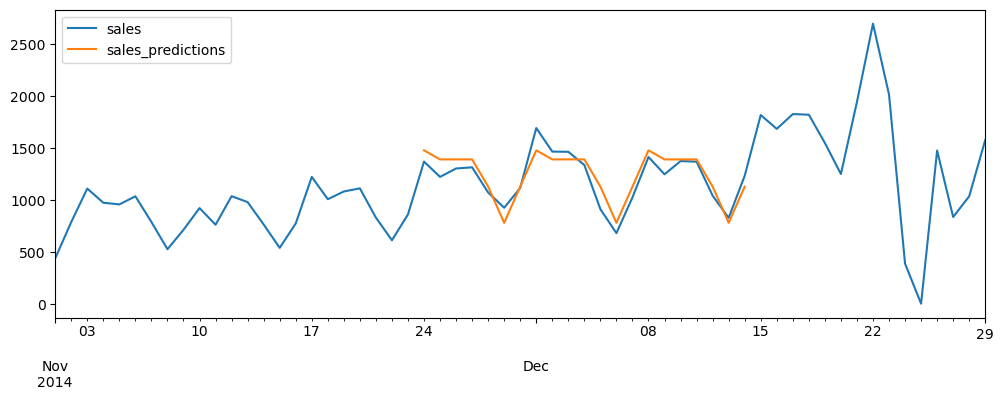

In [156]:
plot_predictions_and_actuals_around(df=s_2, date=pd.Timestamp('2014-11-30'))

2015-03-15 00:00:00


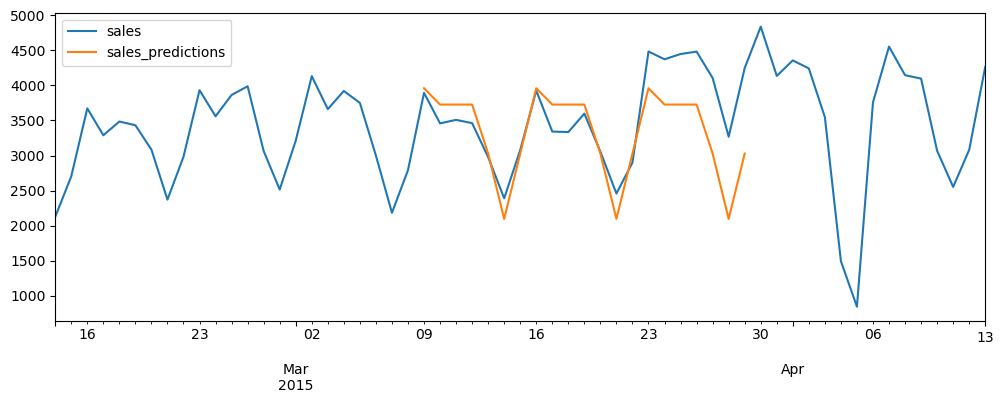

In [157]:
plot_predictions_and_actuals_around(df=s_1, date=pd.Timestamp('2015-3-15'))

2015-05-10 00:00:00


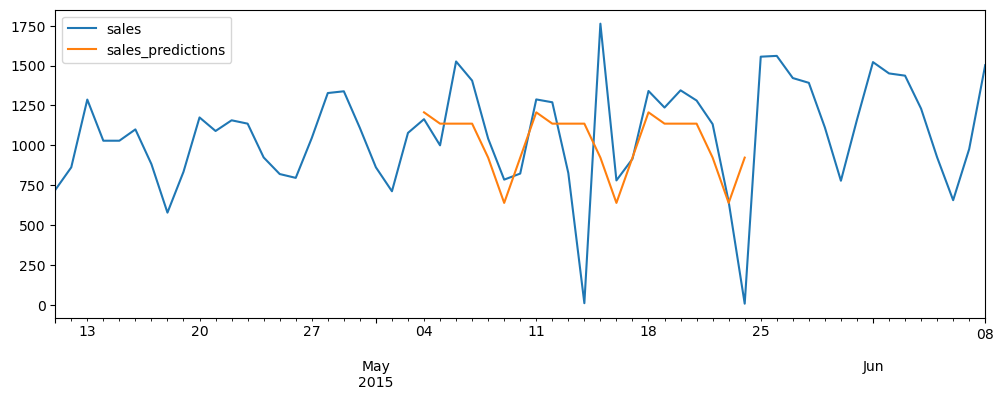

In [158]:
plot_predictions_and_actuals_around(df=s_2, date=pd.Timestamp('2015-5-10'))

2014-11-17 00:00:00


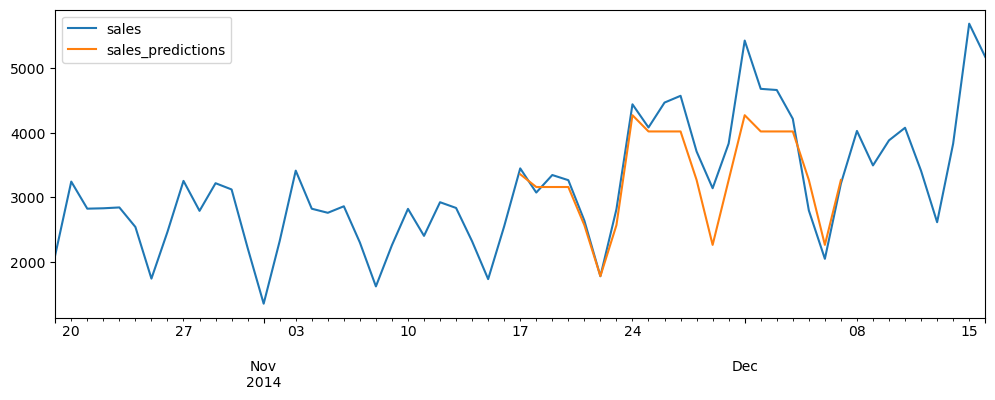

In [159]:
plot_predictions_and_actuals_around(df=s_1, date=pd.Timestamp('2014-11-17'))

2014-09-05 00:00:00


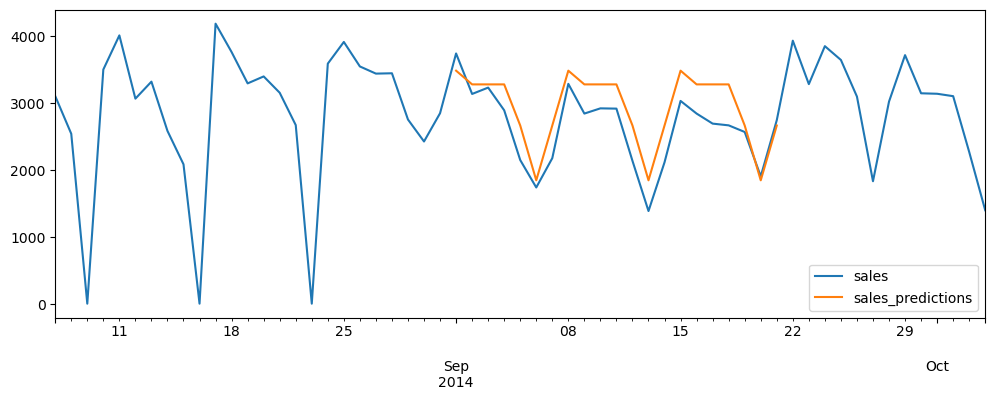

In [160]:
plot_predictions_and_actuals_around(df=s_1, date=pd.Timestamp('2014-9-05'))

In [161]:
plot_predictions_and_actuals_around(df=s_2, date=pd.Timestamp('2013-11-30'))

2013-11-30 00:00:00


## Some more Plots

In [162]:
sales_data['date'] = sales_data.index

In [163]:
sales_data[ sales_data.serieNames == "serie_1"].groupby([pd.Grouper(key='date', freq='W-MON')])['sales'].sum().plot(title="weekly sales sums",figsize=(12,4))

<Axes: title={'center': 'weekly sales sums'}, xlabel='date'>

In [164]:
sales_data[ sales_data.serieNames == "serie_2"].groupby([pd.Grouper(key='date', freq='W')])['sales'].sum().plot(title="weekly sales sums",figsize=(12,4))

<Axes: title={'center': 'weekly sales sums'}, xlabel='date'>

In [165]:
test = pd.read_csv("test.csv", parse_dates=["TSDate"], index_col="TSDate")

In [166]:
plot_predictions_and_actuals_around(df=s_1, date=pd.Timestamp('2015-11-16'))

2015-11-16 00:00:00


2015-11-16 00:00:00


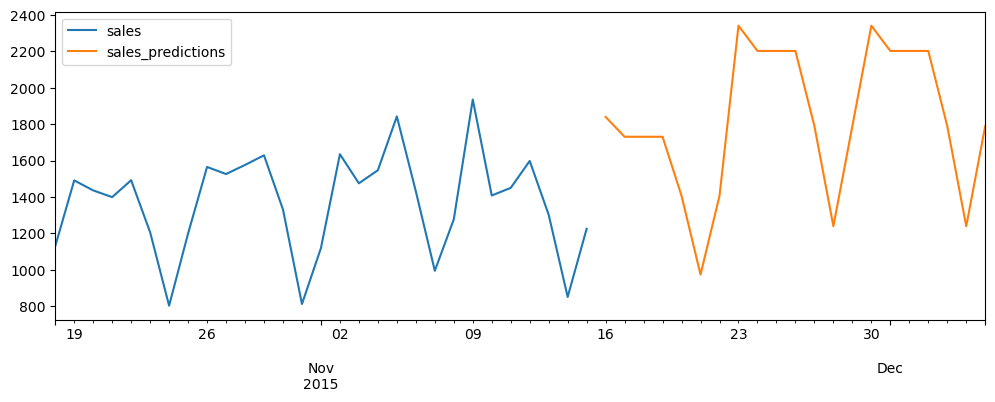

In [167]:
plot_predictions_and_actuals_around(df=s_2, date=pd.Timestamp('2015-11-16'))

In [168]:
serie_1_predictions = add_rolling_mean_predictions(s_1, date_to_start_predictions=pd.Timestamp('2015-11-16'), add_name=True)
serie_2_predictions = add_rolling_mean_predictions(s_2, date_to_start_predictions=pd.Timestamp('2015-11-16'), add_name=True)

In [169]:
predictions = pd.concat([serie_1_predictions,serie_2_predictions])

In [170]:
predictions['TSDate'] = predictions.index
predictions = predictions.rename( {'sales_predictions': 'sales'} , axis=1)
predictions = predictions.sort_index()
predictions = predictions[ predictions.index <= pd.Timestamp('2015-11-30')]

In [171]:
predictions[['TSDate','serieNames','sales']].to_csv('test_willem.csv', index=False)

## 15 days ahead predictions & graphs

In [176]:
def day_factor(day):
    return week_pattern.get(day, 100)

In [177]:
s_1['week'] = s_1.index.isocalendar().week
s_1['factor'] = s_1['week'].map(special_event_factor)

In [178]:
def predict_next_n_days(df, n=15):
    df=df.copy()
    df['week'] = df.index.isocalendar().week
    df['day_of_week'] = df.index.day_of_week
    df['day_factor'] = df['day_of_week'].map(day_factor)
    df['factor'] = df['week'].map(special_event_factor)
    df['sales_norm'] = df['sales'] / ( (df['factor'] + 1)/2 )
    df['rolling_sum'] = df['sales_norm'].rolling(21).sum()
    df['week_average'] = df['rolling_sum'] / 3
    df['week_average_shifted'] = df['week_average'].shift(n)
    df['prediction'] = df['week_average_shifted'] * df['day_factor'] * df['factor']
    
    return df

In [179]:
predict_next_n_days(s_1).head(25)

serieNames  sales       date  week  factor  day_of_week   
TSDate                                                               
2013-06-21    serie_1   1248 2013-06-21    25     1.0            4  \
2013-06-22    serie_1      0 2013-06-22    25     1.0            5   
2013-06-23    serie_1      0 2013-06-23    25     1.0            6   
2013-06-24    serie_1   3393 2013-06-24    26     1.0            0   
2013-06-25    serie_1   1767 2013-06-25    26     1.0            1   
2013-06-26    serie_1   1663 2013-06-26    26     1.0            2   
2013-06-27    serie_1   1611 2013-06-27    26     1.0            3   
2013-06-28    serie_1   1113 2013-06-28    26     1.0            4   
2013-06-29    serie_1      0 2013-06-29    26     1.0            5   
2013-06-30    serie_1      0 2013-06-30    26     1.0            6   
2013-07-01    serie_1   3220 2013-07-01    27     1.0            0   
2013-07-02    serie_1   1947 2013-07-02    27     1.0            1   
2013-07-03    serie_1   1769 2013-07-03    27     1.0            2   
2013-07-04    serie_1   1721 2013-07-04    27     1.0            3   
2013-07-05    serie_1   1107 2013-07-05    27     1.0            4   
2013-07-06    serie_1      0 2013-07-06    27     1.0            5   
2013-07-07    serie_1      0 2013-07-07    27     1.0            6   
2013-07-08    serie_1   2821 2013-07-08    28     1.0            0   
2013-07-09    serie_1   1621 2013-07-09    28     1.0            1   
2013-07-10    serie_1   1673 2013-07-10    28     1.0            2   
2013-07-11    serie_1   1640 2013-07-11    28     1.0            3   
2013-07-12    serie_1   1102 2013-07-12    28     1.0            4   
2013-07-13    serie_1      0 2013-07-13    28     1.0            5   
2013-07-14    serie_1      0 2013-07-14    28     1.0            6   
2013-07-15    serie_1   2891 2013-07-15    29     1.0            0   

            day_factor  sales_norm  rolling_sum  week_average   
TSDate                                                          
2013-06-21        0.13      1248.0          NaN           NaN  \
2013-06-22        0.09         0.0          NaN           NaN   
2013-06-23        0.13         0.0          NaN           NaN   
2013-06-24        0.17      3393.0          NaN           NaN   
2013-06-25        0.16      1767.0          NaN           NaN   
2013-06-26        0.16      1663.0          NaN           NaN   
2013-06-27        0.16      1611.0          NaN           NaN   
2013-06-28        0.13      1113.0          NaN           NaN   
2013-06-29        0.09         0.0          NaN           NaN   
2013-06-30        0.13         0.0          NaN           NaN   
2013-07-01        0.17      3220.0          NaN           NaN   
2013-07-02        0.16      1947.0          NaN           NaN   
2013-07-03        0.16      1769.0          NaN           NaN   
2013-07-04        0.16      1721.0          NaN           NaN   
2013-07-05        0.13      1107.0          NaN           NaN   
2013-07-06        0.09         0.0          NaN           NaN   
2013-07-07        0.13         0.0          NaN           NaN   
2013-07-08        0.17      2821.0          NaN           NaN   
2013-07-09        0.16      1621.0          NaN           NaN   
2013-07-10        0.16      1673.0          NaN           NaN   
2013-07-11        0.16      1640.0      28314.0   9438.000000   
2013-07-12        0.13      1102.0      28168.0   9389.333333   
2013-07-13        0.09         0.0      28168.0   9389.333333   
2013-07-14        0.13         0.0      28168.0   9389.333333   
2013-07-15        0.17      2891.0      27666.0   9222.000000   

            week_average_shifted  prediction  
TSDate                                        
2013-06-21                   NaN         NaN  
2013-06-22                   NaN         NaN  
2013-06-23                   NaN         NaN  
2013-06-24                   NaN         NaN  
2013-06-25                   NaN         NaN  
2013-06-26                   NaN   

In [180]:
s_1 = sales_data[sales_data.serieNames=="serie_1"].copy()
s_2 = sales_data[sales_data.serieNames=="serie_2"].copy()

s_1['date'] = s_1.index
s_2['date'] = s_2.index

s1_15 = predict_next_n_days(s_1,n=15)
s2_15 = predict_next_n_days(s_1,n=15)

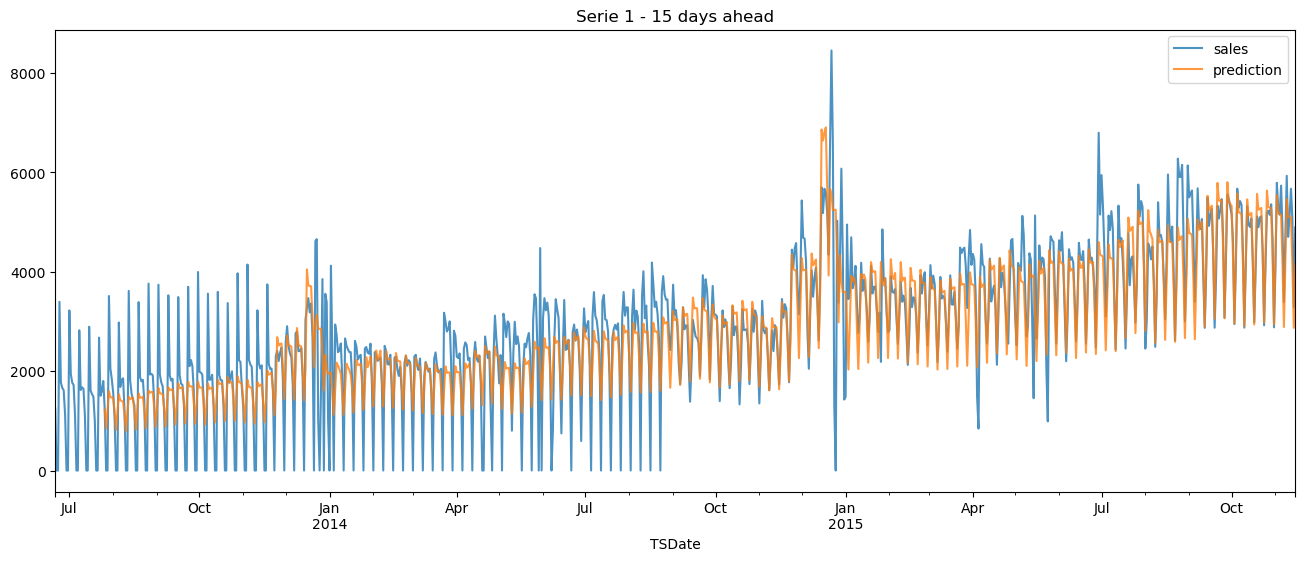

In [181]:
_ = s1_15[['sales','prediction']].plot(figsize=(16,6), alpha=.8, title="Serie 1 - 15 days ahead")

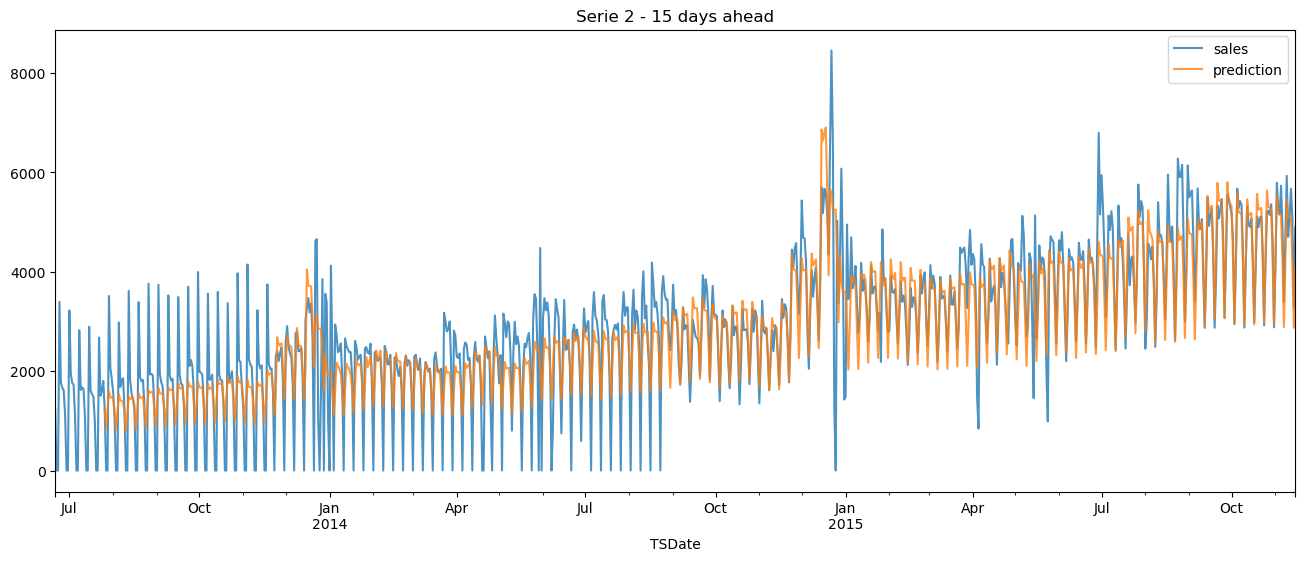

In [182]:
_ = s2_15[['sales','prediction']].plot(figsize=(16,6), alpha=.8, title="Serie 2 - 15 days ahead")

### Matrix Profiling with `stumpy`



In [223]:
import stumpy

mp1 = stumpy.stump( s_1['sales'].astype(float).values , 7)
mp2 = stumpy.stump( s_2['sales'].astype(float).values , 7)

series_1_mp = pd.DataFrame( mp1[:,0] , columns=["MP"])
series_1_mp['sales'] = s_1['sales'].values[6:]
series_1_mp.index = s_1.index[6:]

series_2_mp = pd.DataFrame( mp2[:,0] , columns=["MP"])
series_2_mp['sales'] = s_2['sales'].values[6:]
series_2_mp.index = s_2.index[6:]

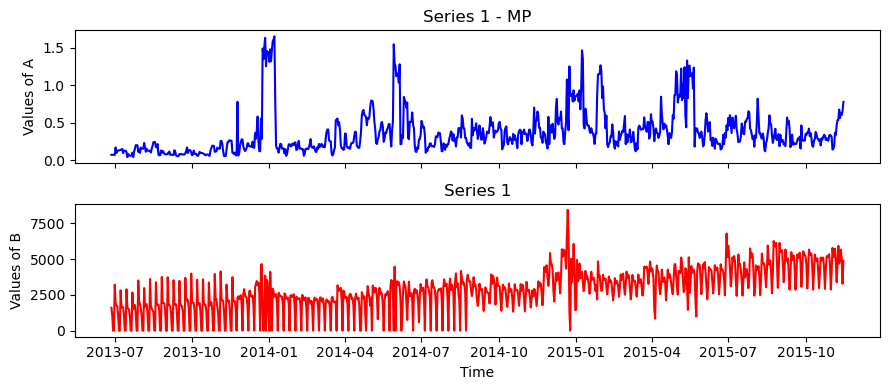

In [224]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, sharex=True, figsize=(9, 4))

# Making the first subplot
axs[0].plot(series_1_mp.index, series_1_mp['MP'], color='blue')
axs[0].set_title('Series 1 - MP')
axs[0].set_ylabel('Values of A')

# Making the second subplot
axs[1].plot(series_1_mp.index, series_1_mp['sales'], color='red')
axs[1].set_title('Series 1')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values of B')

# Displaying the plot
plt.tight_layout()
plt.show()

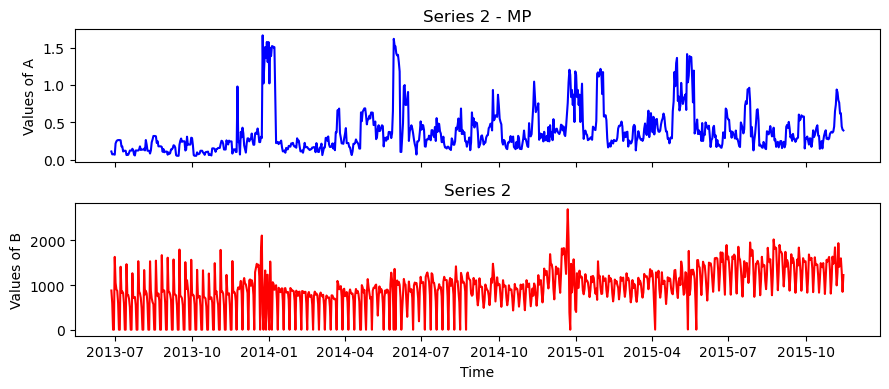

In [225]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, sharex=True, figsize=(9, 4))

# Making the first subplot
axs[0].plot(series_2_mp.index, series_2_mp['MP'], color='blue')
axs[0].set_title('Series 2 - MP')
axs[0].set_ylabel('Values of A')

# Making the second subplot
axs[1].plot(series_2_mp.index, series_2_mp['sales'], color='red')
axs[1].set_title('Series 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values of B')

# Displaying the plot
plt.tight_layout()
plt.show()